In [ ]:
pip install python-sat

In [ ]:
from pysat.solvers import Glucose3
from pysat.formula import CNF
from itertools import combinations
import time
import tracemalloc

# Tạo lớp biến hỗ trợ tương tự như VariableFactory(ex)
class VariableFactory:
    def __init__(self):
        # Khởi tạo đếm số lượng biến (bắt đầu từ 1)
        self.var_count = 1

        # Lưu trữ các biến theo tên (tên -> id biến)
        self.vars = {}

        # Lưu trữ các biến theo id (id -> tên biến)
        self.reverse_vars = {}

    # Hàm lấy id của một biến từ tên, nếu chưa có biến đó thì tạo mới
    def get_var(self, name):
        # Nếu tên biến chưa tồn tại trong self.vars, ta tạo mới id cho biến đó
        if name not in self.vars:
            # Gán id mới cho biến
            self.vars[name] = self.var_count
            # Lưu tên của biến theo id mới
            self.reverse_vars[self.var_count] = name
            # Tăng số lượng biến
            self.var_count += 1
        # Trả về id của biến đã được tạo ra (hoặc đã tồn tại)
        return self.vars[name]

    # Hàm tạo biến bắt đầu của hoạt động tại một thời điểm
    def start(self, activity_id, time):
        # Tạo tên biến theo cú pháp 'start_{activity_id}_{time}'
        return self.get_var(f'start_{activity_id}_{time}')

    # Hàm tạo biến chạy của hoạt động tại một thời điểm
    def run(self, activity_id, time):
        # Tạo tên biến theo cú pháp 'run_{activity_id}_{time}'
        return self.get_var(f'run_{activity_id}_{time}')

    # Hàm tạo biến tiêu thụ tài nguyên của hoạt động tại một thời điểm
    def consume(self, activity_id, resource_id, time, index):
        # Tạo tên biến theo cú pháp 'consume_{activity_id}_{resource_id}_{time}_{index}'
        return self.get_var(f'consume_{activity_id}_{resource_id}_{time}_{index}')

    # Hàm tạo biến phụ trợ (auxiliary variable) tại một thời điểm
    def aux(self, time):
        # Tạo tên biến theo cú pháp 'aux_{time}'
        return self.get_var(f'aux_{time}')

    # Hàm lấy tên của một biến từ id của nó
    def get_var_name(self, var_id):
        # Trả về tên của biến từ id, nếu không tìm thấy trả về None
        return self.reverse_vars.get(var_id, None)



In [ ]:
# Khởi tạo bộ giải SAT và factory tạo biến
solver = Glucose3()
vf = VariableFactory()

In [ ]:
# Hàm thêm mệnh đề vào solver
def add_clause(solver, clause):
    solver.add_clause(clause)

Các hàm encode_relation_fs, encode_relation_ss, encode_relation_ff, và encode_relation_sf bên dưới mô tả các phép toán liên quan đến quan hệ thứ tự giữa các hoạt động trong bài toán lập lịch dự án. Các phép toán này được sử dụng để mô hình hóa các ràng buộc thứ tự giữa các hoạt động (activities). Mỗi hàm mô phỏng một loại quan hệ khác nhau.

- Quan hệ Finish-to-Start (FS) có nghĩa là hoạt động thứ hai (activity2) không thể bắt đầu cho đến khi hoạt động thứ nhất (activity1) kết thúc. Điều này có thể được hiểu là: activity2 bắt đầu sau khi activity1 hoàn thành.
- Mục tiêu: Đảm bảo rằng không có thời điểm nào activity2 có thể bắt đầu cho đến khi activity1 hoàn thành.

- Quan hệ Start-to-Start (SS) có nghĩa là hoạt động thứ hai (activity2) không thể bắt đầu cho đến khi hoạt động thứ nhất (activity1) bắt đầu. Điều này có thể được hiểu là: activity2 không thể bắt đầu trước khi activity1 bắt đầu.
- Mục tiêu: Đảm bảo rằng activity2 không thể bắt đầu trước khi activity1 bắt đầu.

- Quan hệ Finish-to-Finish (FF) có nghĩa là hoạt động thứ hai (activity2) không thể hoàn thành trước khi hoạt động thứ nhất (activity1) hoàn thành. Điều này có thể được hiểu là: activity2 chỉ có thể kết thúc sau khi activity1 kết thúc.
- Mục tiêu: Đảm bảo rằng activity2 không thể hoàn thành trước khi activity1 kết thúc.

- Quan hệ Start-to-Finish (SF) có nghĩa là hoạt động thứ hai (activity2) không thể hoàn thành cho đến khi hoạt động thứ nhất (activity1) bắt đầu. Điều này có thể được hiểu là: activity2 không thể hoàn thành cho đến khi activity1 bắt đầu.
- Mục tiêu: Đảm bảo rằng activity2 không thể kết thúc trước khi activity1 bắt đầu.



In [ ]:
# Phép toán (1) đến (4): Quan hệ thứ tự giữa các hoạt động

# encode_relation_fs: Quan hệ "Finish-to-Start" (FS)
def encode_relation_fs(solver, vf, max_time, activity1_id, activity2_id, duration1):
    for t in range(max_time):
        start1 = vf.start(activity1_id, t) # Tạo biến bắt đầu của activity1 tại thời điểm t
        for k in range(t + duration1):     # Kiểm tra tất cả thời điểm k từ t đến (t + duration1)
            add_clause(solver, [-start1, -vf.start(activity2_id, k)]) # Không thể bắt đầu activity2 tại thời điểm k


# encode_relation_ss: Quan hệ "Start-to-Start" (SS)
def encode_relation_ss(solver, vf, max_time, activity1_id, activity2_id):
    for t in range(max_time):
        start1 = vf.start(activity1_id, t) # Tạo biến bắt đầu của activity1 tại thời điểm t
        for k in range(t):                 # Kiểm tra các thời điểm trước thời điểm t
            add_clause(solver, [-start1, -vf.start(activity2_id, k)]) # Không thể bắt đầu activity2 tại thời điểm k

# encode_relation_ff: Quan hệ "Finish-to-Finish" (FF)
def encode_relation_ff(solver, vf, max_time, activity1_id, activity2_id, duration1, duration2):
    for t in range(max_time - duration2):
        start1 = vf.start(activity1_id, t)         # Tạo biến bắt đầu của activity1 tại thời điểm t
        for k in range(t + duration1 - duration2): # Kiểm tra thời điểm k sau khi (t + duration1 - duration2)
            add_clause(solver, [-start1, -vf.start(activity2_id, k)]) # Không thể bắt đầu activity2 tại thời điểm k

# encode_relation_sf: Quan hệ "Start-to-Finish" (SF)
def encode_relation_sf(solver, vf, max_time, activity1_id, activity2_id, duration2):
    for t in range(max_time):
        start1 = vf.start(activity1_id, t)         # Tạo biến bắt đầu của activity1 tại thời điểm t
        for k in range(max(0, t - duration2 + 1)): # Kiểm tra các thời điểm trước thời điểm t + duration2
            add_clause(solver, [-start1, -vf.start(activity2_id, k)]) # Không thể bắt đầu activity2 tại thời điểm k

Phép toán (6) trong bài toán lập lịch yêu cầu đảm bảo rằng mỗi hoạt động chỉ có một thời điểm bắt đầu duy nhất. Với mỗi hoạt động, phải chắc chắn rằng không thể có hai thời điểm mà tại đó hoạt động này bắt đầu cùng một lúc.

Mục đích của hàm encode_unique_start_instant:
Hàm này sẽ tạo ra các mệnh đề SAT để đảm bảo rằng mỗi hoạt động có chỉ một thời điểm duy nhất để bắt đầu trong khoảng thời gian max_time.

In [ ]:
# Phép toán (6) - ALK: Hoạt động bắt đầu muộn nhất có thể
def encode_unique_start_instant_alk(solver, vf, max_time, activity_id, duration):
    clause = [vf.start(activity_id, t) for t in range(max_time - duration + 1)]
    add_clause(solver, clause)
    for t1 in range(max_time - duration + 1):
        for t2 in range(t1 + 1, max_time - duration + 1):
            add_clause(solver, [-vf.start(activity_id, t1), -vf.start(activity_id, t2)])

Phép toán (7) trong bài toán lập lịch yêu cầu rằng hoạt động không thể bắt đầu quá muộn. Điều này có nghĩa là thời điểm bắt đầu của một hoạt động phải nằm trong một phạm vi hợp lý, không thể muộn hơn một thời điểm nhất định. Cụ thể, nếu một hoạt động có thời gian thực hiện (duration), thì thời điểm bắt đầu của nó không thể muộn hơn một mốc thời gian nhất định mà tại đó nó sẽ không kịp hoàn thành.

Mục đích của hàm encode_start_in_time:
Hàm này sẽ tạo ra các mệnh đề SAT để đảm bảo rằng hoạt động activity_id không thể bắt đầu quá muộn, tức là thời điểm bắt đầu của nó phải nằm trong khoảng từ 0 đến max_time - duration.

In [ ]:
# Phép toán (7): Giới hạn thời gian bắt đầu
def encode_start_in_time(solver, vf, max_time, activity_id, duration):
    for t in range(max_time - duration + 1, max_time):  #Lặp qua các thời điểm bắt đầu hợp lệ
        add_clause(solver, [-vf.start(activity_id, t)]) #Thêm mệnh đề SAT đảm bảo rằng không thể bắt đầu tại các thời điểm quá muộn

Mục đích của hàm encode_runtime:
Hàm này tạo ra các mệnh đề SAT để đảm bảo rằng một khi một hoạt động bắt đầu tại một thời điểm t, nó sẽ tiếp tục thực hiện trong suốt duration đơn vị thời gian và không thể thực hiện trước khi bắt đầu hoặc sau khi kết thúc.

In [ ]:
# Phép toán (8) và (9): Đảm bảo hoạt động chạy liên tục
def encode_runtime(solver, vf, max_time, activity_id, duration):
    for t in range(max_time):  # Lặp qua tất cả các thời điểm t từ 0 đến max_time-1
        start_literal = vf.start(activity_id, t)  # Biến biểu thị việc hoạt động bắt đầu tại thời điểm t
        for j in range(max_time):  # Lặp qua tất cả các thời điểm j từ 0 đến max_time-1
            run_literal = vf.run(activity_id, j)  # Biến biểu thị việc hoạt động đang chạy tại thời điểm j
            if j < t:  # Nếu thời điểm j trước thời điểm t
                add_clause(solver, [-start_literal, -run_literal])  # Mệnh đề: Nếu hoạt động không bắt đầu tại t, thì không thể chạy tại j
            elif t <= j < t + duration:  # Nếu thời điểm j nằm trong khoảng từ t đến t+duration-1
                add_clause(solver, [-start_literal, run_literal])  # Mệnh đề: Nếu hoạt động bắt đầu tại t, thì hoạt động phải chạy tại j
            else:  # Nếu thời điểm j sau thời gian thực hiện của hoạt động (sau t + duration - 1)
                add_clause(solver, [-start_literal, -run_literal])  # Mệnh đề: Nếu hoạt động không bắt đầu tại t, thì không thể chạy tại j

In [ ]:
# Phép toán (10): Quan hệ "finish-to-start"
def encode_relation_fs(solver, vf, max_time, activity1_id, activity2_id, duration1):
    for t in range(max_time):
        start1 = vf.start(activity1_id, t)
        for k in range(t + duration1):
            add_clause(solver, [-start1, -vf.start(activity2_id, k)])

In [ ]:
# Phép toán (11): Quan hệ bắt đầu-bắt đầu (Start-to-Start, SS)
def encode_relation_ss(solver, vf, max_time, activity1_id, activity2_id):
    for t in range(max_time):
        start1 = vf.start(activity1_id, t)
        for k in range(t):
            add_clause(solver, [-start1, -vf.start(activity2_id, k)])

# Phép toán (12): Quan hệ kết thúc-kết thúc (Finish-to-Finish, FF)
def encode_relation_ff(solver, vf, max_time, activity1_id, activity2_id, duration1, duration2):
    for t in range(max_time - duration1 + 1):
        finish1 = vf.start(activity1_id, t)  # end of activity1
        for k in range(max_time - duration2 + 1):
            if k < t + duration1 - duration2:
                add_clause(solver, [-finish1, -vf.start(activity2_id, k)])

# Phép toán (13): Quan hệ bắt đầu-kết thúc (Start-to-Finish, SF)
def encode_relation_sf(solver, vf, max_time, activity1_id, activity2_id, duration2):
    for t in range(max_time):
        start1 = vf.start(activity1_id, t)
        for k in range(t + duration2, max_time):
            add_clause(solver, [-start1, -vf.start(activity2_id, k)])

Mục đích của hàm encode_workload:
Hàm encode_workload thêm các ràng buộc vào bộ giải SAT để đảm bảo rằng tại mỗi thời điểm trong khoảng thời gian từ 0 đến max_time - 1, có ít nhất một hoạt động đang chạy. Nó sử dụng một biến phụ aux_t tại mỗi thời điểm t để biểu diễn việc "lấp đầy" thời gian đó với các hoạt động.

In [ ]:
# Phép toán (14) và (15): Đảm bảo không có thời gian trống trong lịch trình
def encode_workload(solver, vf, max_time, activities):
    aux_vars = []  # Danh sách chứa các biến phụ cho mỗi thời điểm t
    for t in range(max_time):  # Lặp qua tất cả các thời điểm từ 0 đến max_time-1
        aux_t = vf.aux(t)  # Tạo một biến phụ aux_t cho thời điểm t
        aux_vars.append(aux_t)  # Thêm biến phụ vào danh sách aux_vars
        clause = [-aux_t] + [vf.run(activity["id"], t) for activity in activities]
        add_clause(solver, clause)  # Mệnh đề: Nếu không có hoạt động nào chạy tại t, thì aux_t phải là False

        # Đảm bảo rằng nếu aux_t là True (tức là có ít nhất một hoạt động đang chạy tại t),
        # thì phải có ít nhất một hoạt động đang chạy tại thời điểm t
        for activity in activities:
            add_clause(solver, [aux_t, -vf.run(activity["id"], t)])

    # Đảm bảo rằng không có thời gian trống liên tiếp trong lịch trình
    for i in range(len(aux_vars) - 1):
        add_clause(solver, [aux_vars[i], -aux_vars[i + 1]])

In [ ]:
# Phép toán (16): Mã hóa các atoms tiêu thụ tài nguyên
def encode_consumption_atoms(solver, vf, max_time, activities, resources):
    for t in range(max_time):
        for activity in activities:
            for resource in resources:
                consumption = activity['consumption'].get(resource['id'], 0)
                # Tạo các biến tiêu thụ tài nguyên nếu cần thiết
                for i in range(consumption):
                    consumption_var = vf.consume(activity["id"], resource["id"], t, i)
                    add_clause(solver, [-vf.run(activity["id"], t), consumption_var])

Phép toán (5) và (17) trong bài toán lập lịch dự án với ràng buộc tài nguyên yêu cầu rằng các tài nguyên không được vượt quá dung lượng của chúng tại mỗi thời điểm trong lịch trình. Điều này có nghĩa là tại mỗi thời điểm t, tổng lượng tài nguyên mà các hoạt động tiêu thụ không được vượt quá số lượng tài nguyên có sẵn.

Hàm encode_resource_constraint chịu trách nhiệm mã hóa các ràng buộc này trong SAT solver. Nó kiểm tra lượng tài nguyên tiêu thụ của các hoạt động tại mỗi thời điểm t và đảm bảo rằng tổng lượng tài nguyên tiêu thụ không vượt quá dung lượng của tài nguyên đó.

In [ ]:
# Phép toán (5) và (17): Ràng buộc tài nguyên
def encode_resource_constraint(solver, vf, max_time, activities, resources):
    for t in range(max_time):  # Lặp qua tất cả các thời điểm từ 0 đến max_time-1
        for resource in resources:  # Lặp qua tất cả các tài nguyên
            consumption_vars = []  # Danh sách chứa các biến thể hiện việc tiêu thụ tài nguyên tại thời điểm t
            for activity in activities:  # Lặp qua tất cả các hoạt động
                if activity["consumption"].get(resource["id"], 0) > 0:  # Kiểm tra hoạt động có tiêu thụ tài nguyên này không
                    for i in range(activity["consumption"][resource["id"]]):  # Lặp qua số lượng tài nguyên mà hoạt động tiêu thụ
                        consumption_vars.append(vf.consume(activity["id"], resource["id"], t, i))  # Tạo biến cho mỗi đơn vị tài nguyên
                        add_clause(solver, [-vf.run(activity["id"], t), consumption_vars[-1]])  # Ràng buộc: Nếu hoạt động không chạy tại t thì không tiêu thụ tài nguyên
            if consumption_vars:  # Nếu có bất kỳ tài nguyên nào được tiêu thụ tại thời điểm t
                gen_cardinality_constraint(solver, consumption_vars, resource["capacity"])  # Đảm bảo tổng tài nguyên tiêu thụ không vượt quá dung lượng của tài nguyên


Hàm gen_cardinality_constraint có nhiệm vụ thêm các ràng buộc về giới hạn số lượng cho các biến boolean trong SAT solver. Cụ thể, nó đảm bảo rằng không có quá nhiều biến trong danh sách variables có giá trị True đồng thời, giới hạn số lượng này bởi một giá trị bound được chỉ định.

In [ ]:
# Hàm giới hạn số lượng
def gen_cardinality_constraint(solver, variables, bound):
  # Nếu số lượng biến trong list nhỏ hơn hoặc bằng giới hạn, không cần phải thêm bất kỳ ràng buộc nào
    if len(variables) <= bound:
        return
    for i in range(len(variables) - bound): # Lặp qua danh sách các biến
        add_clause(solver, [-var for var in variables[i:i + bound + 1]])  # Thêm ràng buộc vào solver

In [ ]:
# Giải mã lời giải thành thông tin dễ hiểu
def decode_solution(model, vf):
    decoded_solution = {
        "activities_start_times": {},
        "activities_runtime": [],
        "resources_usage": []
    }

    for var in model:
        if var > 0:
            var_name = vf.get_var_name(abs(var))
            if "start" in var_name:
                parts = var_name.split('_')
                activity_id = int(parts[1])
                time = int(parts[2])
                decoded_solution["activities_start_times"][activity_id] = time
            elif "run" in var_name:
                parts = var_name.split('_')
                activity_id = int(parts[1])
                time = int(parts[2])
                decoded_solution["activities_runtime"].append((activity_id, time))
            elif "consume" in var_name:
                parts = var_name.split('_')
                activity_id = int(parts[1])
                resource_id = int(parts[2])
                time = int(parts[3])
                decoded_solution["resources_usage"].append((activity_id, resource_id, time))

    return decoded_solution

In [ ]:
# Advanced output display
def print_solution(solution):
    print("Thời gian bắt đầu của mỗi hoạt động:")
    for activity, start_time in solution['activities_start_times'].items():
        print(f"  - Hoạt động {activity} bắt đầu tại thời điểm {start_time}")

    print("\nThời gian chạy của mỗi hoạt động:")
    for activity, time in solution['activities_runtime']:
        print(f"  - Hoạt động {activity} đang chạy tại thời điểm {time}")

    print("\nTiêu thụ tài nguyên theo thời gian:")
    resource_usage = {}
    for activity, resource, time in solution['resources_usage']:
        if time not in resource_usage:
            resource_usage[time] = []
        resource_usage[time].append((activity, resource))

    for time, usages in resource_usage.items():
        print(f"  - Tại thời điểm {time}:")
        for activity, resource in usages:
            print(f"    + Hoạt động {activity} tiêu thụ Tài nguyên {resource}")

/Hoạt động (activities):

Mỗi hoạt động có id, duration (thời gian thực hiện), và consumption (tài nguyên tiêu thụ theo dạng {resource_id: quantity}).
Ví dụ: Hoạt động 3 yêu cầu 3 đơn vị tài nguyên 1 và 1 đơn vị tài nguyên 2.

/Tài nguyên (resources):

Mỗi tài nguyên có id và capacity (khả năng cung cấp tối đa).
Ví dụ: Tài nguyên 1 có khả năng cung cấp tối đa 5 đơn vị tại mỗi thời điểm.

/Quan hệ phụ thuộc (encode_relation_fs):

(Thêm một vài quan hệ phụ thuộc giữa các hoạt động. Ví dụ, hoạt động 1 phải hoàn thành trước khi hoạt động 2 có thể bắt đầu, và hoạt động 3 phải hoàn thành trước khi hoạt động 4 bắt đầu.)

/Giới hạn thời gian (max_time):
Đặt max_time = 20 để có nhiều thời gian hơn cho các hoạt động, giúp bài toán có thêm không gian để tối ưu.

In [ ]:
# Input
activities = [
    {"id": 0, "duration": 308, "name": "Task 0"},
    {"id": 1, "duration": 10, "name": "Task 1"},
    {"id": 2, "duration": 1, "name": "Task 2"},
    {"id": 3, "duration": 20, "name": "Task 3"},
    {"id": 4, "duration": 2, "name": "Task 4"},
    {"id": 5, "duration": 5, "name": "Task 5"},
    {"id": 6, "duration": 1, "name": "Task 6"}
]

relations = [
    {"task_id_1": 1, "task_id_2": 2, "relation_type": "ea"},
    {"task_id_1": 2, "task_id_2": 3, "relation_type": "ea"},
    {"task_id_1": 3, "task_id_2": 4, "relation_type": "ea"},
    {"task_id_1": 4, "task_id_2": 5, "relation_type": "ea"},
    {"task_id_1": 5, "task_id_2": 6, "relation_type": "ea"}
]

consumptions = [
    {"task_id": 1, "resource_id": 0, "amount": -3},
    {"task_id": 3, "resource_id": 0, "amount": -3},
    {"task_id": 3, "resource_id": 1, "amount": -3},
    {"task_id": 3, "resource_id": 2, "amount": -3},
    {"task_id": 4, "resource_id": 0, "amount": -3},
    {"task_id": 4, "resource_id": 3, "amount": -3},
    {"task_id": 4, "resource_id": 4, "amount": -3},
    {"task_id": 5, "resource_id": 0, "amount": -3},
    {"task_id": 5, "resource_id": 3, "amount": -3},
    {"task_id": 5, "resource_id": 4, "amount": -3}
]

resources = [
    {"id": 0, "capacity": 8, "name": "Resource 0"},
    {"id": 1, "capacity": 8, "name": "Resource 1"},
    {"id": 2, "capacity": 8, "name": "Resource 2"},
    {"id": 3, "capacity": 8, "name": "Resource 3"},
    {"id": 4, "capacity": 8, "name": "Resource 4"},
    {"id": 5, "capacity": 8, "name": "Resource 5"},
    {"id": 6, "capacity": 8, "name": "Resource 6"},
    {"id": 7, "capacity": 8, "name": "Resource 7"},
    {"id": 8, "capacity": 8, "name": "Resource 8"},
    {"id": 9, "capacity": 8, "name": "Resource 9"},
    {"id": 10, "capacity": 8, "name": "Resource 10"}
]

max_time = 350  # Thiết lập thời gian tối đa cho lịch trình
# Use encode_relation_ss, encode_relation_ff, and encode_relation_sf when encoding
# add specific cases based on the relations list:
for relation in relations:
    if relation["relation_type"] == "ea":
        encode_relation_fs(solver, vf, max_time, relation["task_id_1"], relation["task_id_2"],
                           next(a["duration"] for a in activities if a["id"] == relation["task_id_1"]))
    elif relation["relation_type"] == "ss":
        encode_relation_ss(solver, vf, max_time, relation["task_id_1"], relation["task_id_2"])
    elif relation["relation_type"] == "ff":
        encode_relation_ff(solver, vf, max_time, relation["task_id_1"], relation["task_id_2"],
                           next(a["duration"] for a in activities if a["id"] == relation["task_id_1"]),
                           next(a["duration"] for a in activities if a["id"] == relation["task_id_2"]))
    elif relation["relation_type"] == "sf":
        encode_relation_sf(solver, vf, max_time, relation["task_id_1"], relation["task_id_2"],
                           next(a["duration"] for a in activities if a["id"] == relation["task_id_2"]))

In [ ]:
# Mã hóa các ràng buộc cho mỗi hoạt động
for activity in activities:
    encode_unique_start_instant(solver, vf, max_time, activity["id"])
    encode_start_in_time(solver, vf, max_time, activity["id"], activity["duration"])
    encode_runtime(solver, vf, max_time, activity["id"], activity["duration"])

# Mã hóa các ràng buộc thứ tự giữa các hoạt động theo quan hệ "finish-start"
for relation in relations:
    encode_relation_fs(solver, vf, max_time, relation["task_id_1"], relation["task_id_2"],
                       next(a["duration"] for a in activities if a["id"] == relation["task_id_1"]))

# Thiết lập cấu trúc tiêu thụ tài nguyên cho mỗi hoạt động, đảm bảo mỗi hoạt động có trường 'consumption'
for activity in activities:
    if "consumption" not in activity:
        activity["consumption"] = {}  # Khởi tạo tiêu thụ tài nguyên trống nếu chưa tồn tại

for consumption in consumptions:
    task_id = consumption["task_id"]
    resource_id = consumption["resource_id"]
    amount = -consumption["amount"]

    for activity in activities:
        if activity["id"] == task_id:
            activity["consumption"][resource_id] = amount

# Mã hóa các ràng buộc về tài nguyên
encode_resource_constraint(solver, vf, max_time, activities, resources)

In [ ]:
# Tính toán
if solver.solve():
    model = solver.get_model()
    solution = decode_solution(model, vf)
    print("Lời giải:")
    print_solution(solution)
else:
    print("Không có lời giải thỏa mãn.")

Lời giải:
Thời gian bắt đầu của mỗi hoạt động:
  - Hoạt động 1 bắt đầu tại thời điểm 3
  - Hoạt động 2 bắt đầu tại thời điểm 13
  - Hoạt động 3 bắt đầu tại thời điểm 25
  - Hoạt động 4 bắt đầu tại thời điểm 99
  - Hoạt động 5 bắt đầu tại thời điểm 122
  - Hoạt động 6 bắt đầu tại thời điểm 299
  - Hoạt động 0 bắt đầu tại thời điểm 4

Thời gian chạy của mỗi hoạt động:
  - Hoạt động 0 đang chạy tại thời điểm 4
  - Hoạt động 0 đang chạy tại thời điểm 5
  - Hoạt động 0 đang chạy tại thời điểm 6
  - Hoạt động 0 đang chạy tại thời điểm 7
  - Hoạt động 0 đang chạy tại thời điểm 8
  - Hoạt động 0 đang chạy tại thời điểm 9
  - Hoạt động 0 đang chạy tại thời điểm 10
  - Hoạt động 0 đang chạy tại thời điểm 11
  - Hoạt động 0 đang chạy tại thời điểm 12
  - Hoạt động 0 đang chạy tại thời điểm 13
  - Hoạt động 0 đang chạy tại thời điểm 14
  - Hoạt động 0 đang chạy tại thời điểm 15
  - Hoạt động 0 đang chạy tại thời điểm 16
  - Hoạt động 0 đang chạy tại thời điểm 17
  - Hoạt động 0 đang chạy tại thời 

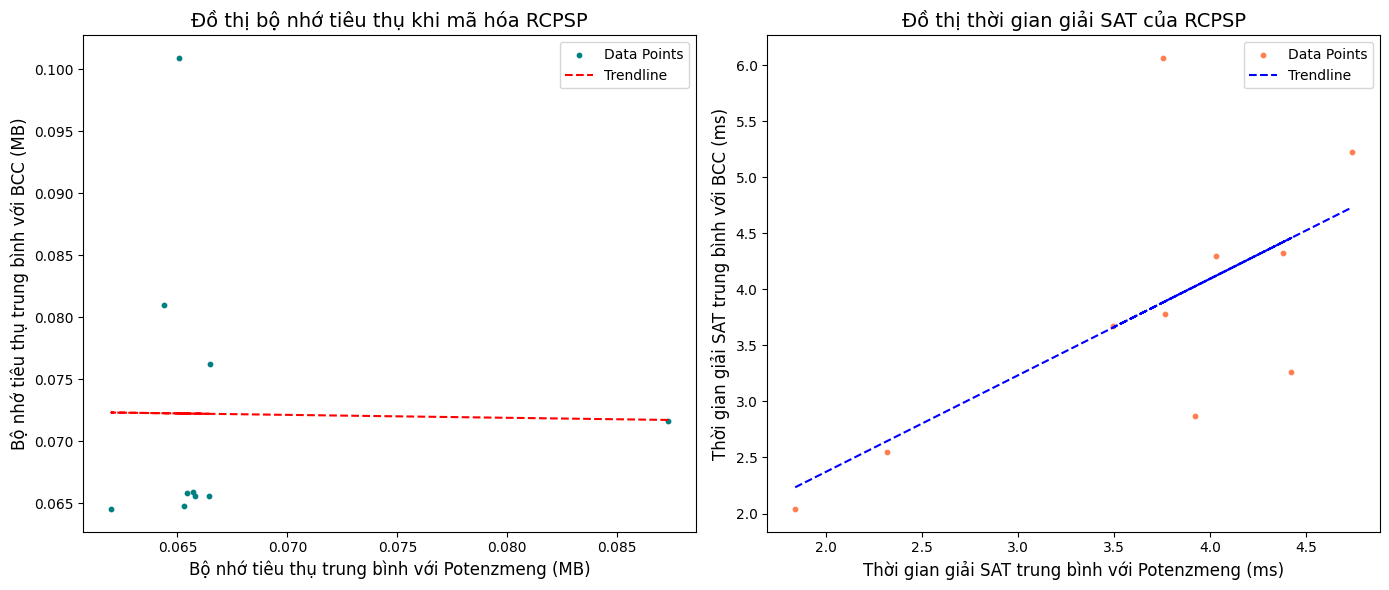

Kết quả trung bình:
Bộ nhớ tiêu thụ trung bình với Potenzmeng: 0.07 MB
Bộ nhớ tiêu thụ trung bình với BCC: 0.07 MB
Thời gian giải SAT trung bình với Potenzmeng: 3.67 ms
Thời gian giải SAT trung bình với BCC: 3.81 ms


In [ ]:
import tracemalloc
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from itertools import combinations

# Hàm đánh giá hiệu suất tiêu thụ bộ nhớ và thời gian giải cho các phương pháp mã hóa
def evaluate_rcpsp_solver(solver, vf, max_time, activities, relations, resources, consumptions, encoding_type):
    tracemalloc.start()  # Khởi động theo dõi bộ nhớ

    # Mã hóa ràng buộc cho hoạt động và tài nguyên dựa trên encoding_type
    for activity in activities:
        encode_unique_start_instant(solver, vf, max_time, activity["id"])
        encode_start_in_time(solver, vf, max_time, activity["id"], activity["duration"])
        encode_runtime(solver, vf, max_time, activity["id"], activity["duration"])

    for relation in relations:
        encode_relation_fs(solver, vf, max_time, relation["task_id_1"], relation["task_id_2"],
                           next(a["duration"] for a in activities if a["id"] == relation["task_id_1"]))

    for activity in activities:
        if "consumption" not in activity:
            activity["consumption"] = {}
    for consumption in consumptions:
        task_id = consumption["task_id"]
        resource_id = consumption["resource_id"]
        amount = -consumption["amount"]
        for activity in activities:
            if activity["id"] == task_id:
                activity["consumption"][resource_id] = amount

    if encoding_type == "Potenzmeng":
        encode_resource_constraint_powerset(solver, vf, max_time, activities, resources)
    elif encoding_type == "BCC":
        encode_resource_constraint_cardinality(solver, vf, max_time, activities, resources)

    # Lưu lượng bộ nhớ sử dụng sau khi mã hóa
    current, peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Đo thời gian giải SAT
    start_time = time.time()
    solver.solve()
    end_time = time.time()
    solve_time = (end_time - start_time) * 1000  # Đổi sang mili giây

    return peak_memory / (1024 * 1024), solve_time  # Đổi sang MB và ms

# Hàm mã hóa tài nguyên tiêu thụ theo phương pháp tập lũy thừa
def encode_resource_constraint_powerset(solver, vf, max_time, activities, resources):
    for t in range(max_time):
        for resource in resources:
            # Xét tất cả các tập hợp con của các hoạt động có thể tiêu thụ tài nguyên
            for subset_size in range(1, len(activities) + 1):
                for subset in combinations(activities, subset_size):
                    consumption_vars = []
                    total_consumption = 0
                    for activity in subset:
                        # Lấy lượng tiêu thụ tài nguyên của hoạt động trong tập con này
                        consumption = activity["consumption"].get(resource["id"], 0)
                        total_consumption += consumption
                        for i in range(consumption):
                            consumption_vars.append(vf.consume(activity["id"], resource["id"], t, i))

                    # Nếu tổng tiêu thụ tài nguyên của tập hợp con vượt quá giới hạn tài nguyên
                    if total_consumption > resource["capacity"]:
                        add_clause(solver, [-var for var in consumption_vars])

# Hàm mã hóa tài nguyên tiêu thụ theo phương pháp BCC
def encode_resource_constraint_cardinality(solver, vf, max_time, activities, resources):
    # Tạo mã hóa ràng buộc tài nguyên tiêu thụ với giới hạn số lượng (BCC)
    encode_consumption_atoms(solver, vf, max_time, activities, resources)
    for t in range(max_time):
        for resource in resources:
            consumption_vars = []
            for activity in activities:
                if activity["consumption"].get(resource["id"], 0) > 0:
                    for i in range(activity["consumption"][resource["id"]]):
                        consumption_vars.append(vf.consume(activity["id"], resource["id"], t, i))
            if consumption_vars:
                gen_cardinality_constraint(solver, consumption_vars, resource["capacity"])

# Lưu kết quả đánh giá số lần chạy
memory_usage_potenzmeng = []
solve_time_potenzmeng = []
memory_usage_bcc = []
solve_time_bcc = []

for _ in range(10): #Số lần chạy
    # Đánh giá cho phương pháp Potenzmeng
    peak_memory_potenzmeng, solve_time_potenzmeng_val = evaluate_rcpsp_solver(
        solver, vf, max_time, activities, relations, resources, consumptions, encoding_type="Potenzmeng"
    )
    memory_usage_potenzmeng.append(peak_memory_potenzmeng)
    solve_time_potenzmeng.append(solve_time_potenzmeng_val)

    # Đánh giá cho phương pháp BCC
    peak_memory_bcc, solve_time_bcc_val = evaluate_rcpsp_solver(
        solver, vf, max_time, activities, relations, resources, consumptions, encoding_type="BCC"
    )
    memory_usage_bcc.append(peak_memory_bcc)
    solve_time_bcc.append(solve_time_bcc_val)

# Vẽ đồ thị và đường fit cho kết quả đánh giá
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Đồ thị 1: Bộ nhớ tiêu thụ khi mã hóa
ax[0].scatter(memory_usage_potenzmeng, memory_usage_bcc, color='teal', s=10, label="Data Points")
ax[0].set_xlabel("Bộ nhớ tiêu thụ trung bình với Potenzmeng (MB)", fontsize=12)
ax[0].set_ylabel("Bộ nhớ tiêu thụ trung bình với BCC (MB)", fontsize=12)
ax[0].set_title("Đồ thị bộ nhớ tiêu thụ khi mã hóa RCPSP", fontsize=14)

# Tính và vẽ đường trendline cho bộ nhớ tiêu thụ
slope, intercept, _, _, _ = linregress(memory_usage_potenzmeng, memory_usage_bcc)
trendline_y = np.array(memory_usage_potenzmeng) * slope + intercept
ax[0].plot(memory_usage_potenzmeng, trendline_y, color='red', linestyle="--", label="Trendline")
ax[0].legend()

# Đồ thị 2: Thời gian giải SAT
ax[1].scatter(solve_time_potenzmeng, solve_time_bcc, color='coral', s=10, label="Data Points")
ax[1].set_xlabel("Thời gian giải SAT trung bình với Potenzmeng (ms)", fontsize=12)
ax[1].set_ylabel("Thời gian giải SAT trung bình với BCC (ms)", fontsize=12)
ax[1].set_title("Đồ thị thời gian giải SAT của RCPSP", fontsize=14)

# Tính và vẽ đường trendline cho thời gian giải SAT
slope, intercept, _, _, _ = linregress(solve_time_potenzmeng, solve_time_bcc)
trendline_y = np.array(solve_time_potenzmeng) * slope + intercept
ax[1].plot(solve_time_potenzmeng, trendline_y, color='blue', linestyle="--", label="Trendline")
ax[1].legend()

plt.tight_layout()
plt.show()

# In kết quả trung bình
print("Kết quả trung bình:")
print(f"Bộ nhớ tiêu thụ trung bình với Potenzmeng: {np.mean(memory_usage_potenzmeng):.2f} MB")
print(f"Bộ nhớ tiêu thụ trung bình với BCC: {np.mean(memory_usage_bcc):.2f} MB")
print(f"Thời gian giải SAT trung bình với Potenzmeng: {np.mean(solve_time_potenzmeng):.2f} ms")
print(f"Thời gian giải SAT trung bình với BCC: {np.mean(solve_time_bcc):.2f} ms")